# Inter-annotator agreement

In [184]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast

In [326]:
importlib.reload(utils)
connection = utils.connectDB()

In [212]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("corrected_GPT_min.csv")

In [213]:
gpt_df.head()

,sentence_id,all_properties,feature_id
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood
2,265,[],Verb_choices
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases


In [379]:
len(gpt_df['sentence_id'].unique())

324

In [377]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[subordinate, adjective]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[prepositional phrases, single word modifiers,..."


## Get annotators data

In [193]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

a_20 = utils.annotationsToGPTFormat(20,annotations)
a_20.groupby("feature_id").agg(list).reset_index().loc[16]['properties']

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


[['right_branching'],
 ['right_branching'],
 ['loose_sentences'],
 ['middle_branching'],
 ['right_branching'],
 ['left_branching'],
 ['left_branching', 'Periodic_sentences'],
 ['right_branching'],
 ['right_branching'],
 ['right_branching'],
 ['Periodic_sentences'],
 ['middle_branching'],
 ['left_branching'],
 ['Periodic_sentences'],
 ['right_branching'],
 ['left_branching'],
 ['right_branching'],
 ['right_branching'],
 ['Periodic_sentences'],
 ['Periodic_sentences'],
 ['left_branching'],
 ['Periodic_sentences'],
 ['left_branching'],
 ['left_branching'],
 ['right_branching', 'left_branching'],
 ['middle_branching'],
 ['Periodic_sentences'],
 ['right_branching'],
 ['right_branching'],
 ['middle_branching'],
 ['left_branching'],
 ['right_branching'],
 ['right_branching'],
 ['left_branching'],
 ['middle_branching'],
 ['right_branching'],
 ['Periodic_sentences'],
 ['left_branching'],
 ['Periodic_sentences'],
 ['Periodic_sentences'],
 ['Periodic_sentences'],
 ['right_branching'],
 ['right_br

## Calculate agreement for a feature using Jaccard similarity

$$ \frac{A \cap B \cap C}{A \cup B \cup C} $$


EXAMPLE:   
* Annotator 1 - {'Language_of_origin': ['Old_English_Core', 'Latin/Greek']}
* Annotator 2 - {'Language_of_origin': ['Latin/Greek']}
* Annotator 3 - {'Language_of_origin': ['Latin/Greek']}





Avg Jaccard for a feature:
    
$$ \frac{\sum{jaccard\ score}}{number\ of\ occurances\ of\ feature} $$

In [21]:
# Example:
s1 = {'Old_English_Core', 'Latin/Greek'}
s2 = {'Latin/Greek'}
s3 = {'Latin/Greek'}

utils.jaccard_score(s1,s2,s3)

0.5

In [45]:
features = list(a_21.groupby('feature_id').agg(list).reset_index()['feature_id'])

In [52]:
features

['Aspect',
 'Emphasis',
 'Figures_of_argument',
 'Figures_of_word_choice',
 'Language_of_origin',
 'Language_varieties',
 'Lexical_and_semantic_fields',
 'Modifying_clauses',
 'Modifying_phrases',
 'Mood',
 'New_words_and_changing_uses',
 'Parallelism',
 'Phrases_built_on_nouns',
 'Phrases_built_on_verbs',
 'Predication',
 'Sentence_architecture',
 'Series',
 'Subject_choices',
 'Tense',
 'Tropes',
 'Verb_choices']

<img src="figures/a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="figures/a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Let's look at the `mood` feature


### Mood properties:
* __indicative__ — denoting a mood of verbs expressing simple statement of a fact (Indicative mood is fact mood, and it's the one we use most often. It states, asks, or denies a fact. However, it can also express an opinion because opinions are often stated as facts).
* __subjunctive__ — relating to or denoting a mood of verbs expressing what is imagined or hypothetical or possible (The subjunctive mood is used to express suggestions, recommendations, advice, demands, wishes, and doubts. It is also used to talk about hypothetical (imaginary) situations or something that is contrary to fact).
* __exclamatory__ — expressing surprise, strong emotion, or pain.
* __interrogative__ — questions
* __imperative__ — commands or directives
* __optative__ — expressing wishes


Let's see the distribution of properties across all sentences which have mood as a feature.

It's clear that `Mood` is most often classified as `indicative`. In fact the vast majority of sentences as classified as `indicative` by both humans and GPT. This skew makes it difficult to interpret the high inter-annotator agreement and ideally should be balanced by the class distribution (akin to a Mathews Correlation Coefficient). This is also challenging as the number of unique classes is the number of combinations of five properties which can be large while the number of datapoints is small. 

It may be more productive to examine the subset of sentences where the `indicative` prediction is not the agreed upon class. That includes everything which is other thatn `indicative` regardless of agreement as well as any sentences where there is disagreement regardless of whether one or more of the predictions is the `indicative` class. 

What does the agreement look like for this subset of predictions?
* the properties that appear to be confused most often are: `indicative` and `subjunctive`. Probabaly because it is sometimes difficult to separate opinion from suggestion.
* the `optative` propoerty occurs only 5 times and is only ever reported by the same annotator, in each case correctly, while the other annotators assign the `indicative` property to those sentences.

On another note, it's interesting to see that one of the annotators assigned multiple properties to a single sentence while the others mainly assigned one.



In [194]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

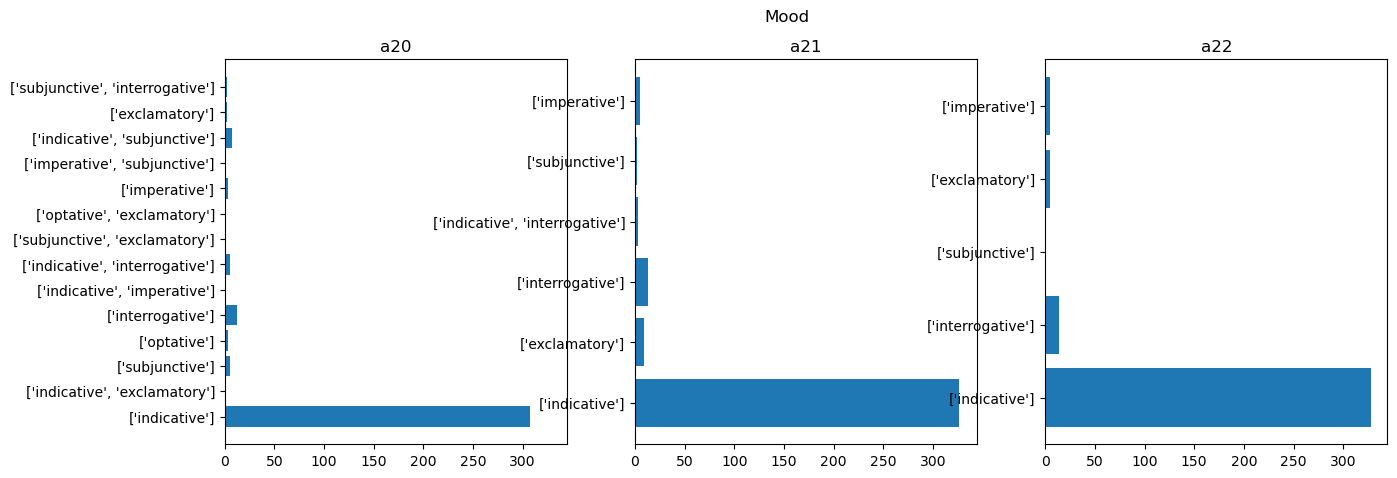

In [208]:
plotPropertyDistributions("Mood",a_20,a_21,a_22)

In [226]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index("Mood")
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]

## For GPT, consolidate the 3X propmts by taking the majority vote

In [260]:
def find_majority(k):
    myMap = {}
    maximum = ('', 0 ) # (occurring element, occurrences)
    for n in k:
        if str(n) in myMap: myMap[str(n)] += 1
        else: myMap[str(n)] = 1
        if myMap[str(n)] > maximum[1]: maximum = (n,myMap[str(n)])
    return maximum

# example
find_majority([{'subjunctive', 'indicative'}, {'indicative'}, {'subjunctive', 'indicative'}])

({'indicative', 'subjunctive'}, 2)

In [261]:
## Some string shenannigans to deal with unhashable types
cGPT = Counter([str(find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

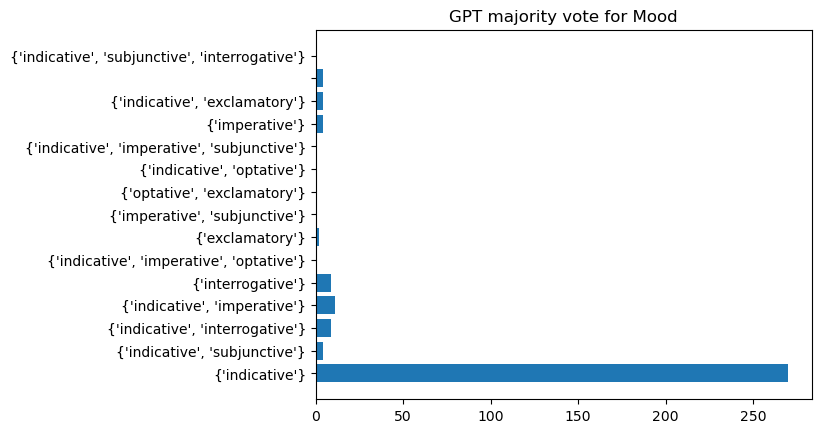

In [262]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for Mood")
plt.show()

## Analyse non-indictative subset

* Find sentences where the annotation is `indicative` for each annotator and GPT
* Take the intersection
* Analyse inter-annotator agrrement of the sentences NOT in this group

In [276]:
a_20['properties']

0                [correctness, clarity]
0                          [indicative]
0                         [Latin/Greek]
0      [gramatical_structure_(parison)]
0                    [by_sentence_role]
                     ...               
356                   [active, stative]
356        [present, progression, past]
356               [simple, progressive]
356                              [noun]
356                          [emphasis]
Name: properties, Length: 4899, dtype: object

In [309]:
a_20_sent = set(a_20[a_20['properties'].apply(lambda x: x == ['indicative'])]['sentence_id'])
a_21_sent = set(a_21[a_21['properties'].apply(lambda x: x == ['indicative'])]['sentence_id'])
a_22_sent = set(a_22[a_22['properties'].apply(lambda x: x == ['indicative'])]['sentence_id'])
gpt_df_sent = set(gpt_df[gpt_df['majority_prop'].apply(lambda x: x == ['indicative'])]['sentence_id'])

In [310]:
all_agreed_sentences = a_20_sent.intersection(a_21_sent,a_22_sent,gpt_df_sent)

In [329]:
_sentIDs = str(all_agreed_sentences).replace("{","(").replace("}",")")
query = 'SELECT id, technique, text FROM ebdb.sample_sentences where id not in '+_sentIDs+';'
non_agreed_sentences = pd.read_sql(query, connection)

In [340]:
non_agreed_sentences['feature_id'] = 'Mood'
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [346]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [347]:
non_agreed_sentences.head()

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Mood,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Mood,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Mood,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Mood,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Mood,,,,


In [383]:
## fill in the annotators and gpt predictions. GPT predictions are the majority vote of three prompts
f = 'Mood'

for row in non_agreed_sentences.iterrows():
    row[1]
    sid = row[1]['sentence_id']
    
    try:
        props_a20 = a_20.loc[(a_20['sentence_id']==sid)&(a_20['feature_id']==f)]['properties'].values[0]
        non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a20'] = \
            non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a20'].apply(lambda x: props_a20)
    except:
        pass
    
    try:
        props_a21 = a_21.loc[(a_21['sentence_id']==sid)&(a_21['feature_id']==f)]['properties'].values[0]
        non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a21'] = \
            non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a21'].apply(lambda x: props_a21)
    except:
        pass
    
    try:
        props_a22 = a_22.loc[(a_22['sentence_id']==sid)&(a_22['feature_id']==f)]['properties'].values[0]
        non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a22'] = \
            non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_a22'].apply(lambda x: props_a22)
    except:
        pass
    
    try:
        props_gpt = gpt_df.loc[(gpt_df['sentence_id']==sid)&(gpt_df['feature_id']==f)]['majority_prop'].values[0]    
        non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_gpt'] = \
            non_agreed_sentences.loc[(non_agreed_sentences['sentence_id'] == sid),'props_gpt'].apply(lambda x: props_gpt)
    except:
        pass
    

In [384]:
non_agreed_sentences.to_csv("non_agreed_sentences.csv",index=None)

## Plot all features

In [206]:
def plotPropertyDistributions(feature,a_20,a_21,a_22):
    
    fig, axs = plt.subplots(1,3, sharex=True,figsize=[15,5])
    
    
    features_20 = list(a_20.groupby('feature_id').agg(list).reset_index()['feature_id'])
    if feature in features_20:
        idx_20 = features_20.index(feature)
        properties_20 = a_20.groupby('feature_id').agg(list).reset_index().loc[idx_20][['properties','sentence_id','technique']]
        c20 = Counter([str(l) for l in properties_20['properties']])
    
        axs[0].barh(list(c20.keys()),list(c20.values()))
    else:
        axs[0].barh([],[])

    axs[0].set_title('a20')
    
        
    features_21 = list(a_21.groupby('feature_id').agg(list).reset_index()['feature_id'])
    if feature in features_21:
        idx_21 = features_21.index(feature)
        properties_21 = a_21.groupby('feature_id').agg(list).reset_index().loc[idx_21][['properties','sentence_id','technique']]
        c21 = Counter([str(l) for l in properties_21['properties']])

        axs[1].barh(list(c21.keys()),list(c21.values()))
        
    else:
        axs[1].barh([],[])
    axs[1].set_title('a21')
        
    
    features_22 = list(a_22.groupby('feature_id').agg(list).reset_index()['feature_id'])
    if feature in features_22:
        idx_22 = features_22.index(feature)
        properties_22 = a_22.groupby('feature_id').agg(list).reset_index().loc[idx_22][['properties','sentence_id','technique']]
        c22 = Counter([str(l) for l in properties_22['properties']])

        axs[2].barh(list(c22.keys()),list(c22.values()))
    else:
        axs[2].barh([],[])
    axs[2].set_title('a22')
    
   
    # fig.autofmt_xdate(rotation=90)
    
    fig.suptitle(feature)
    plt.show()

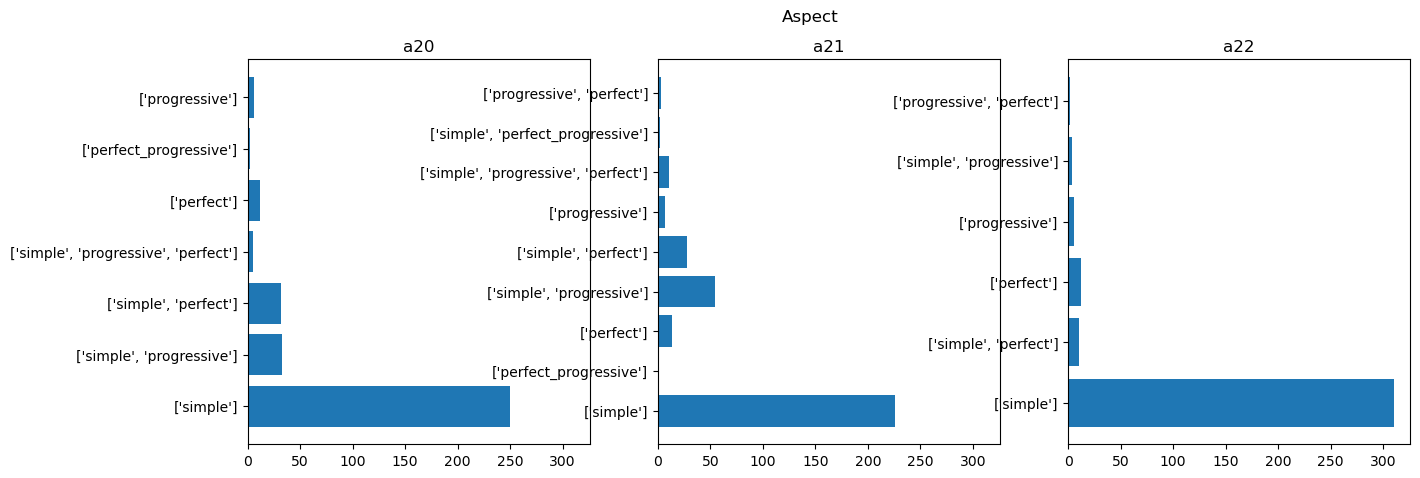

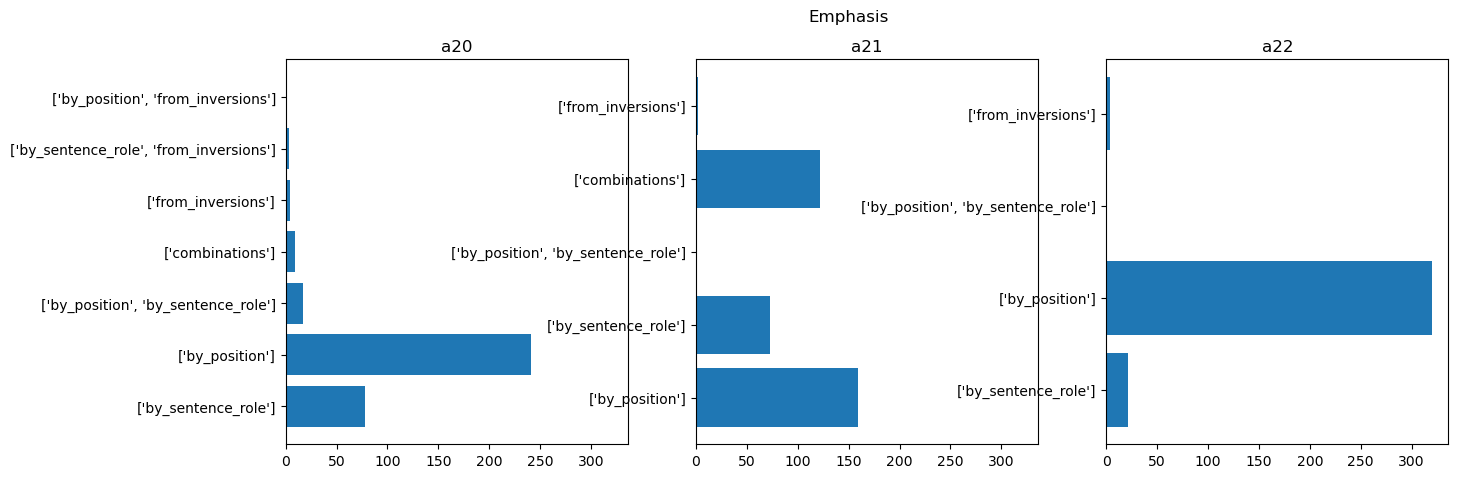

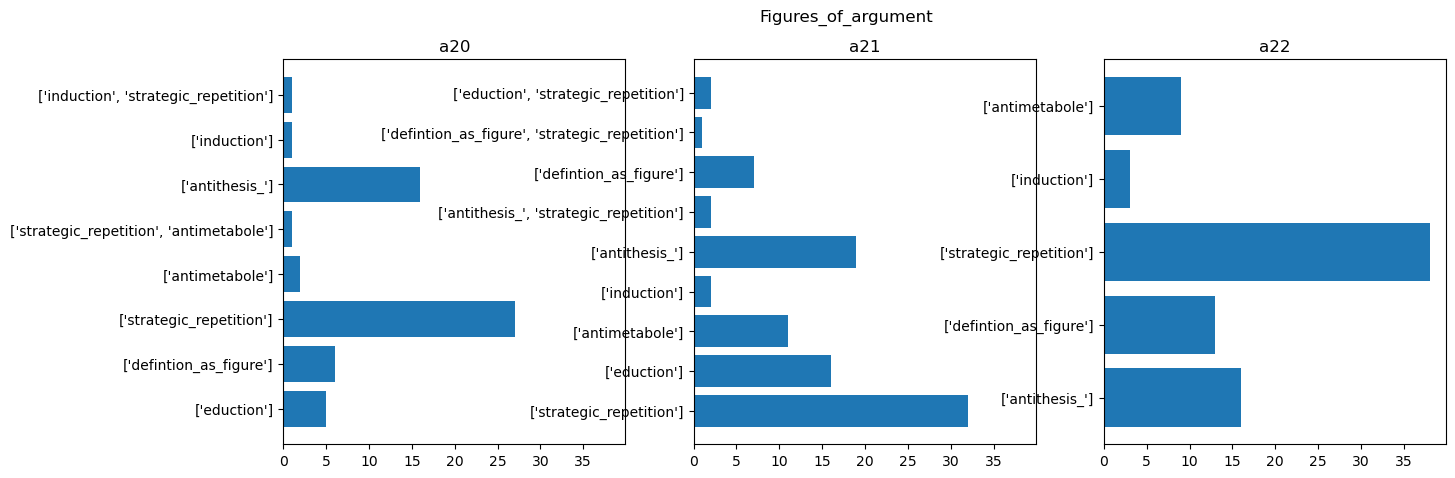

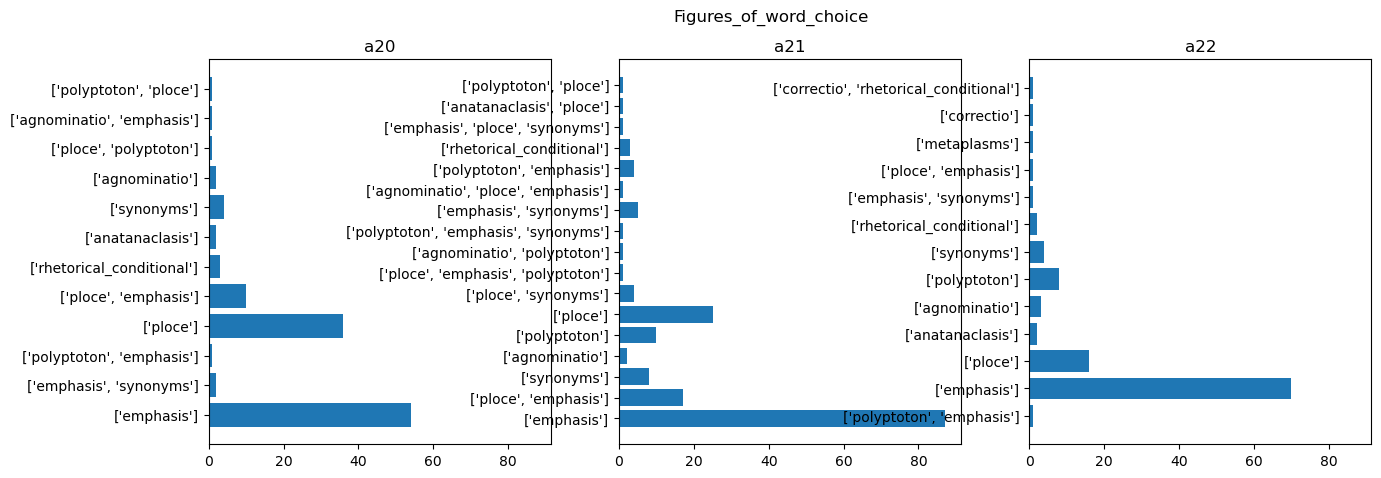

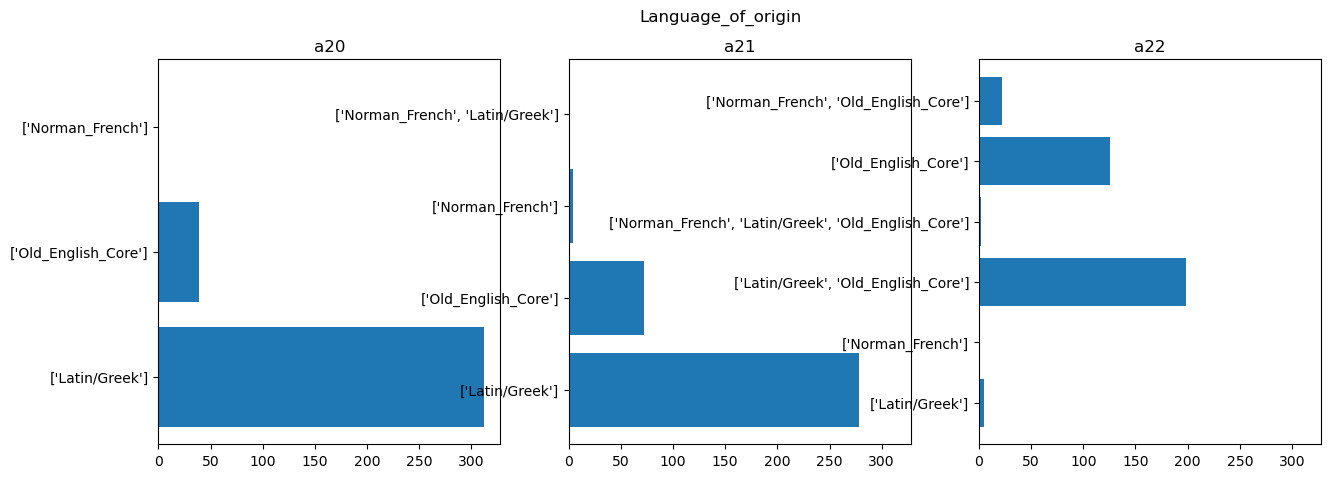

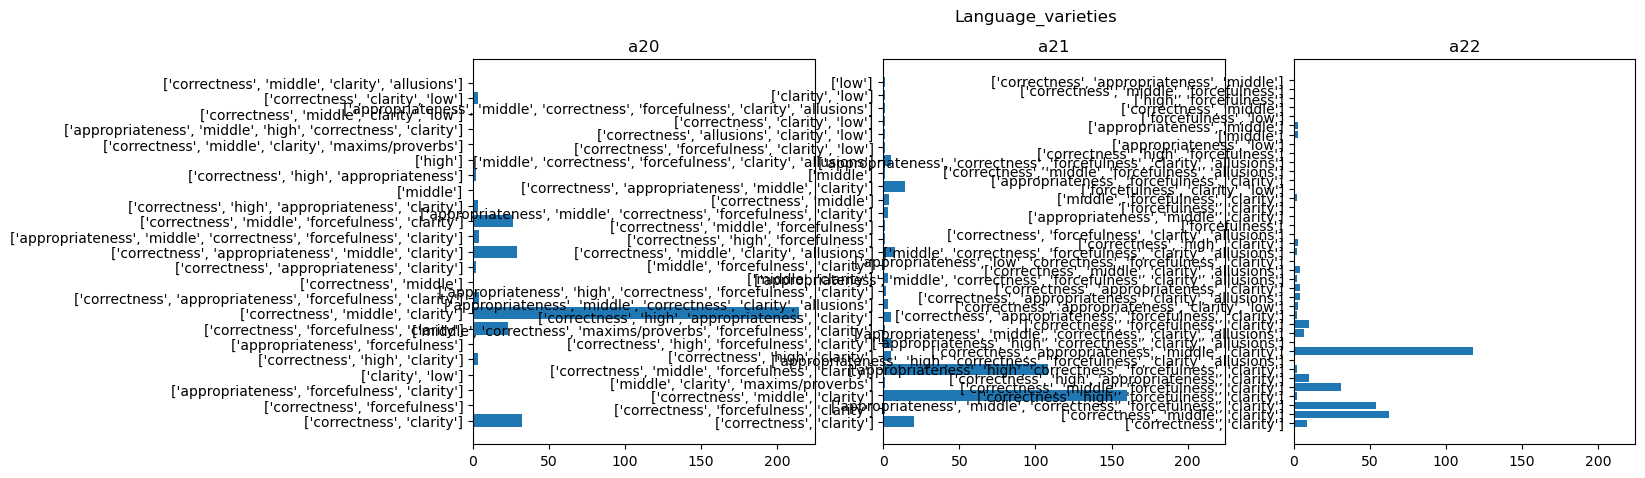

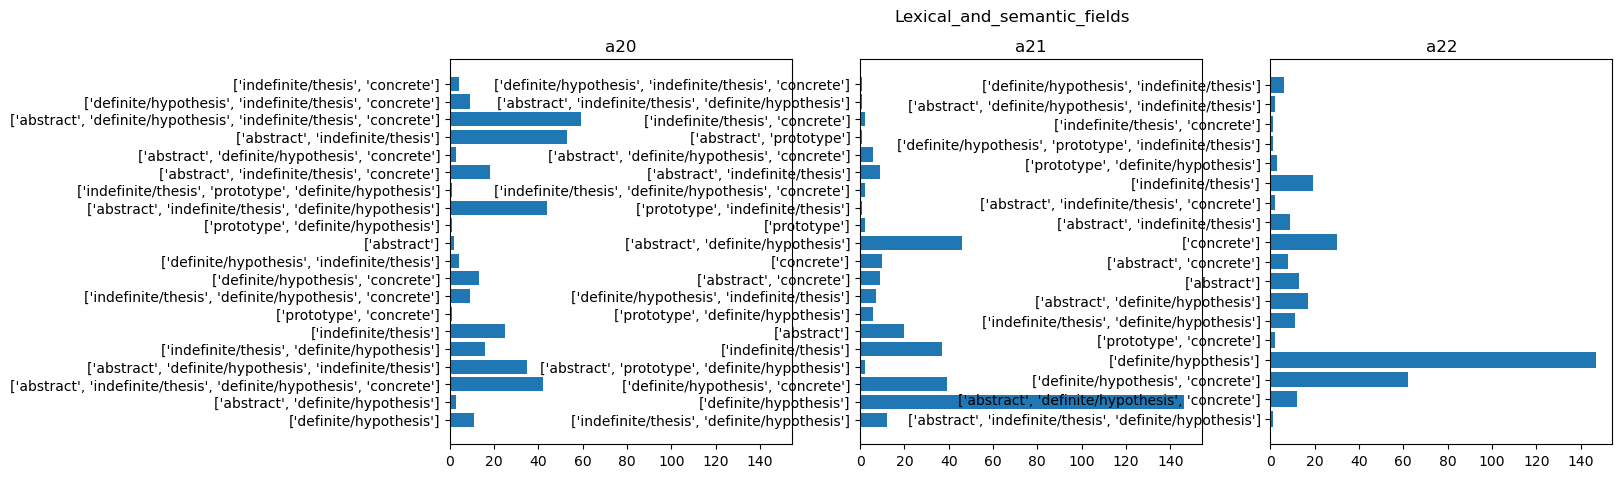

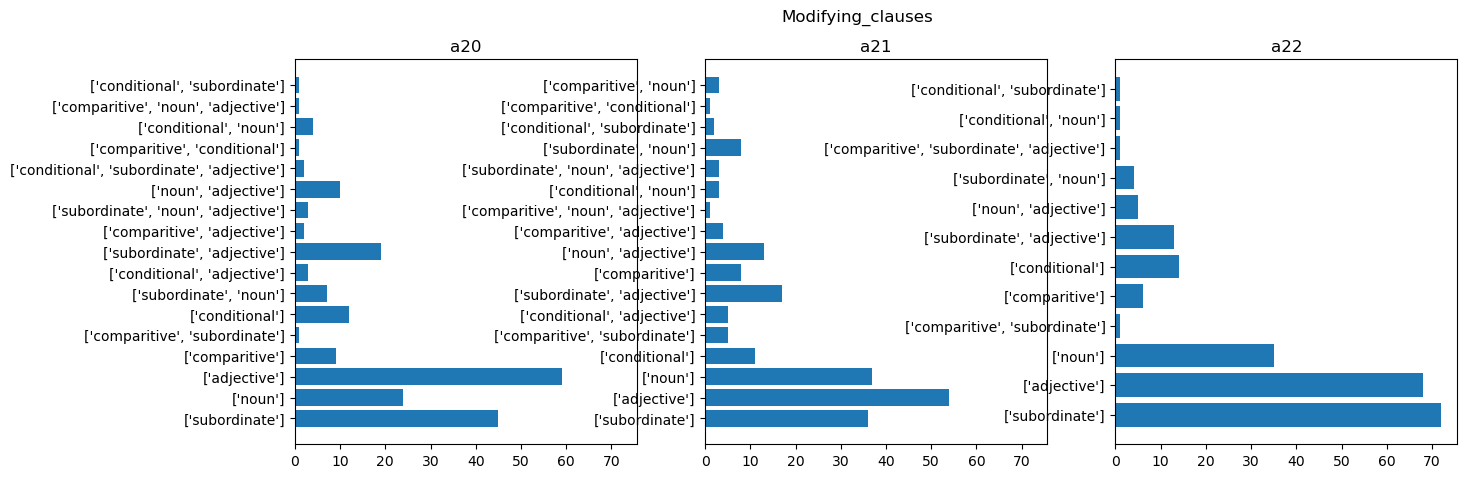

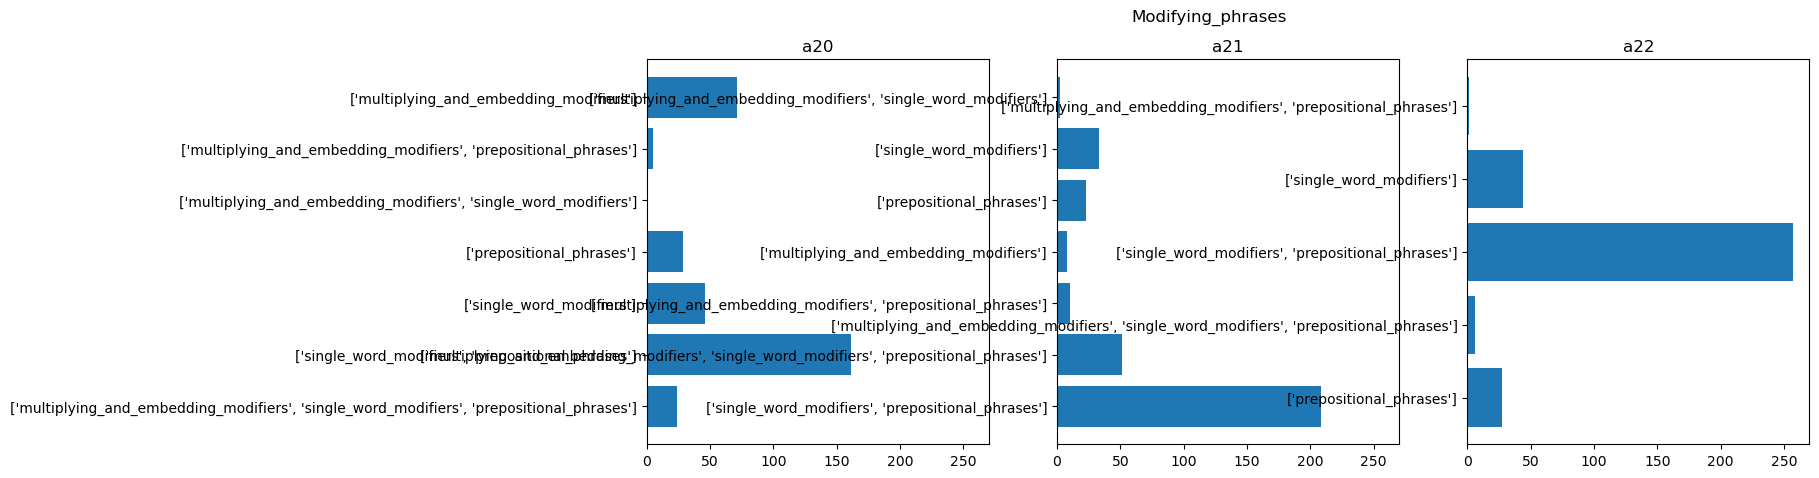

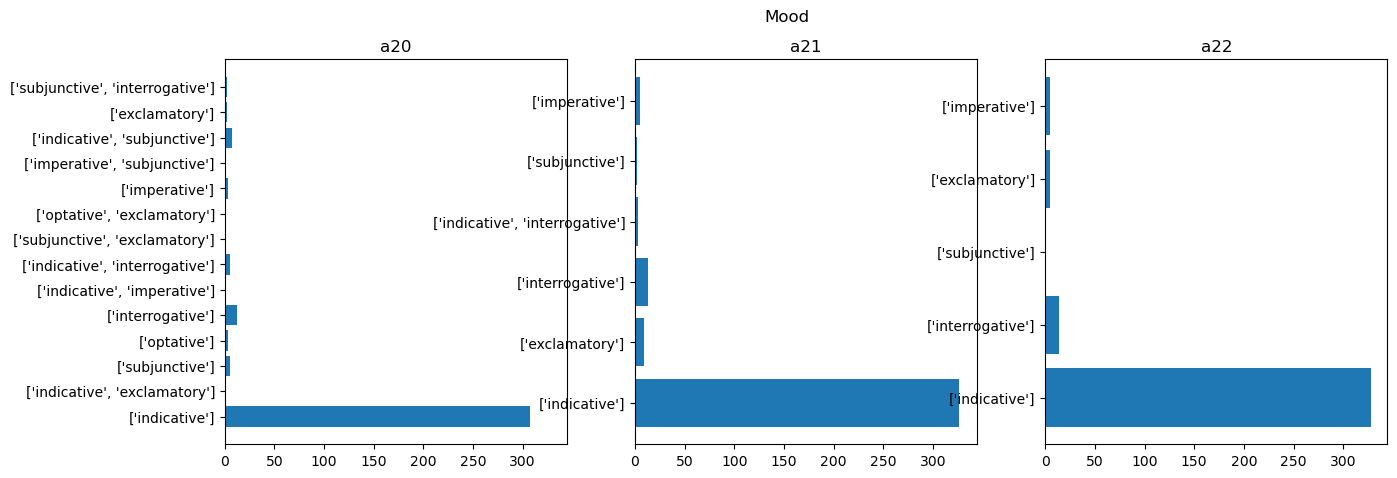

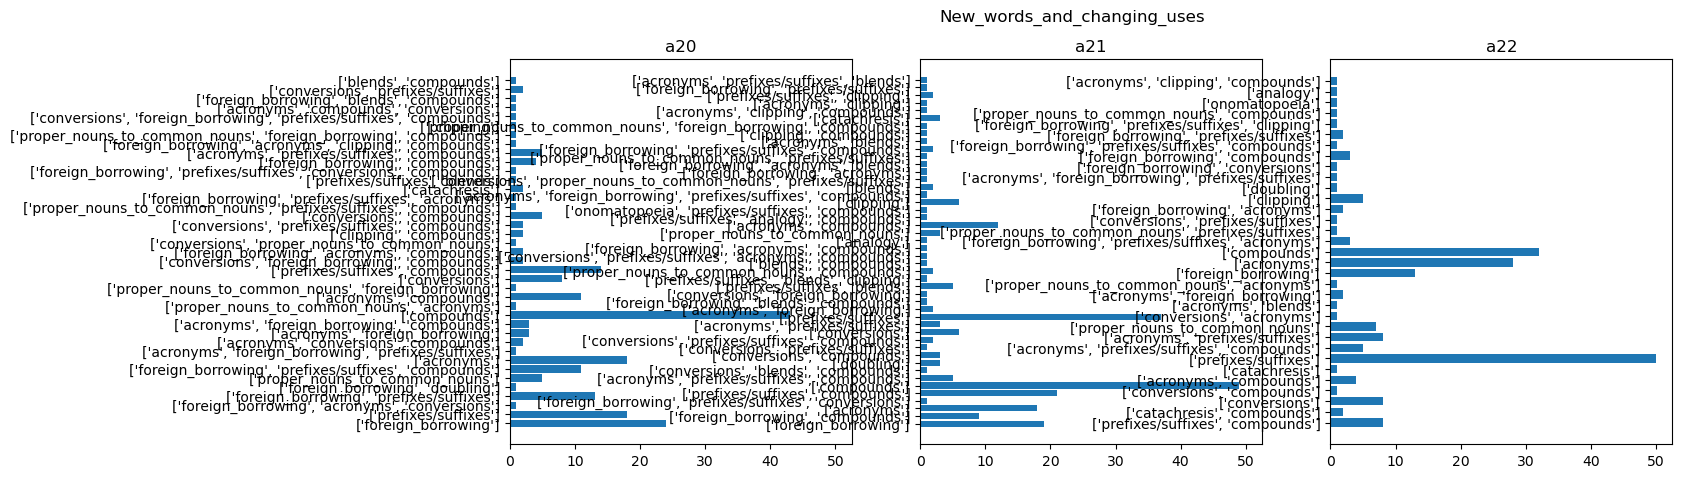

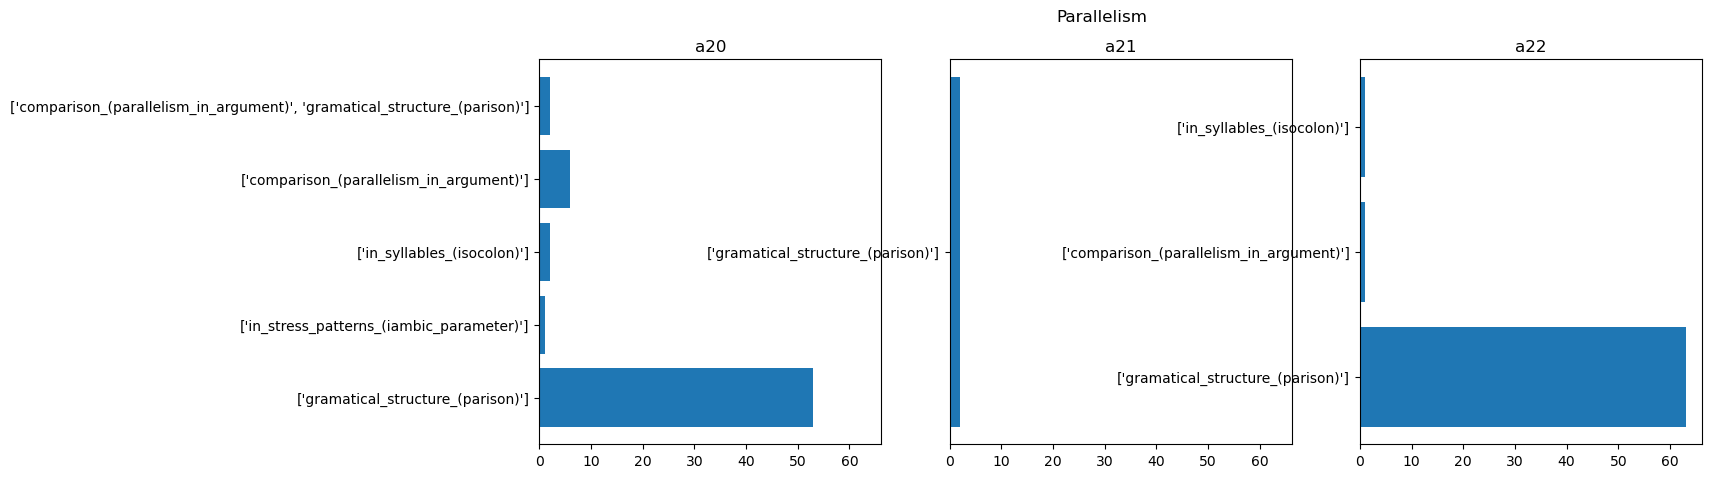

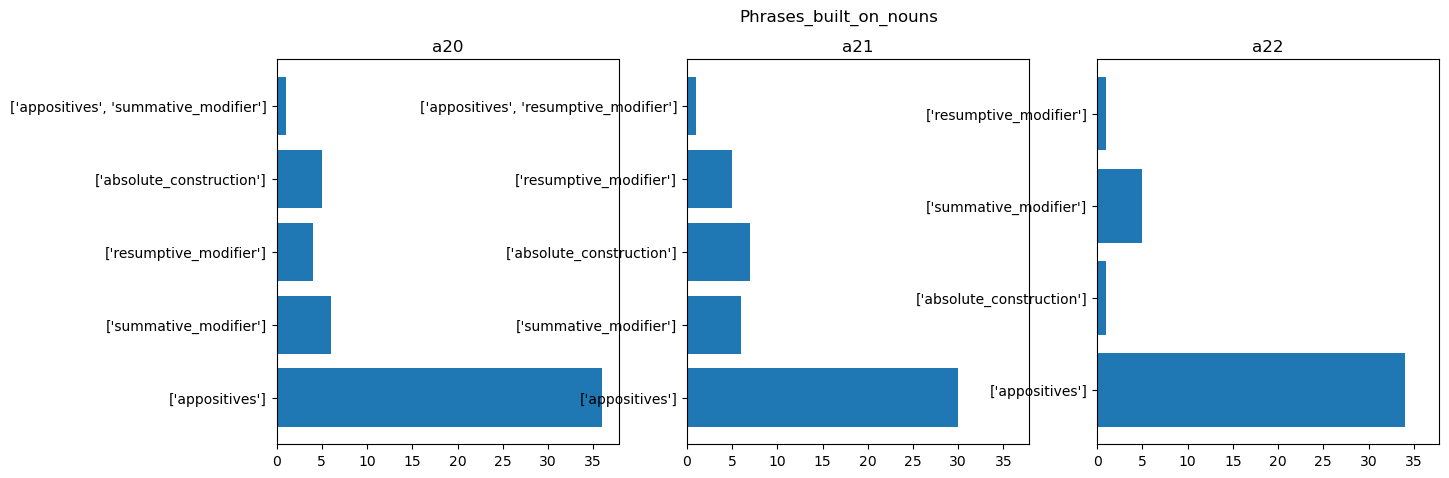

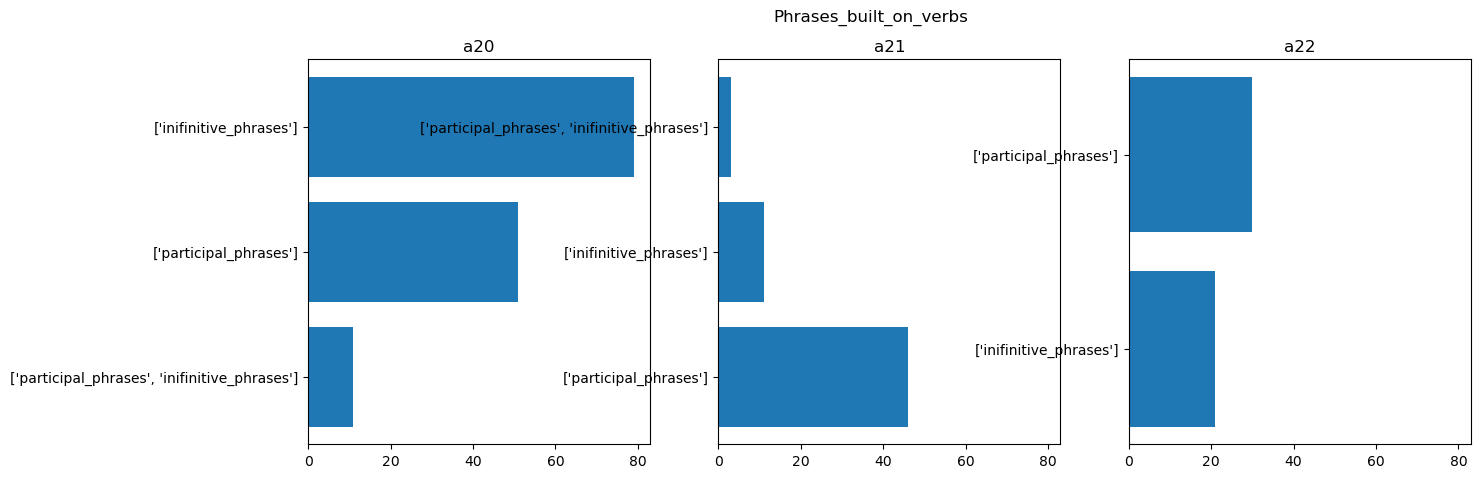

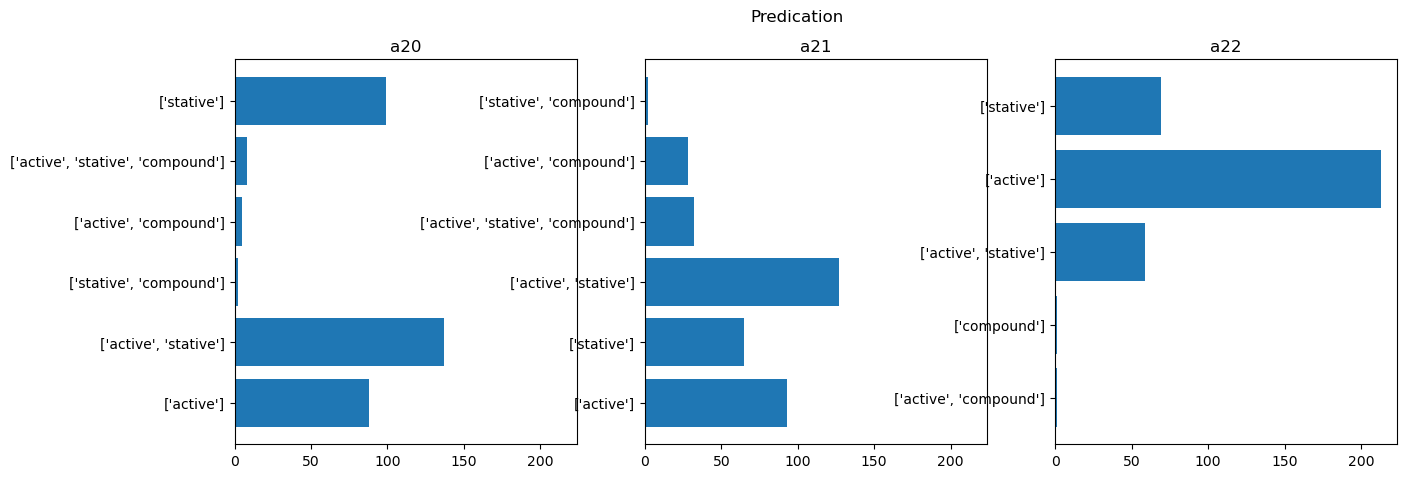

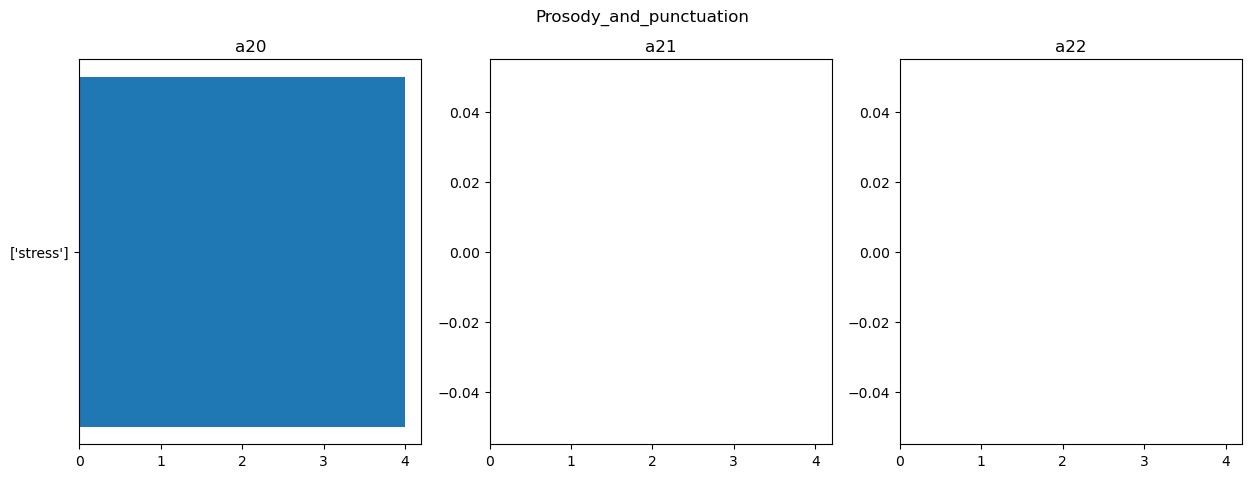

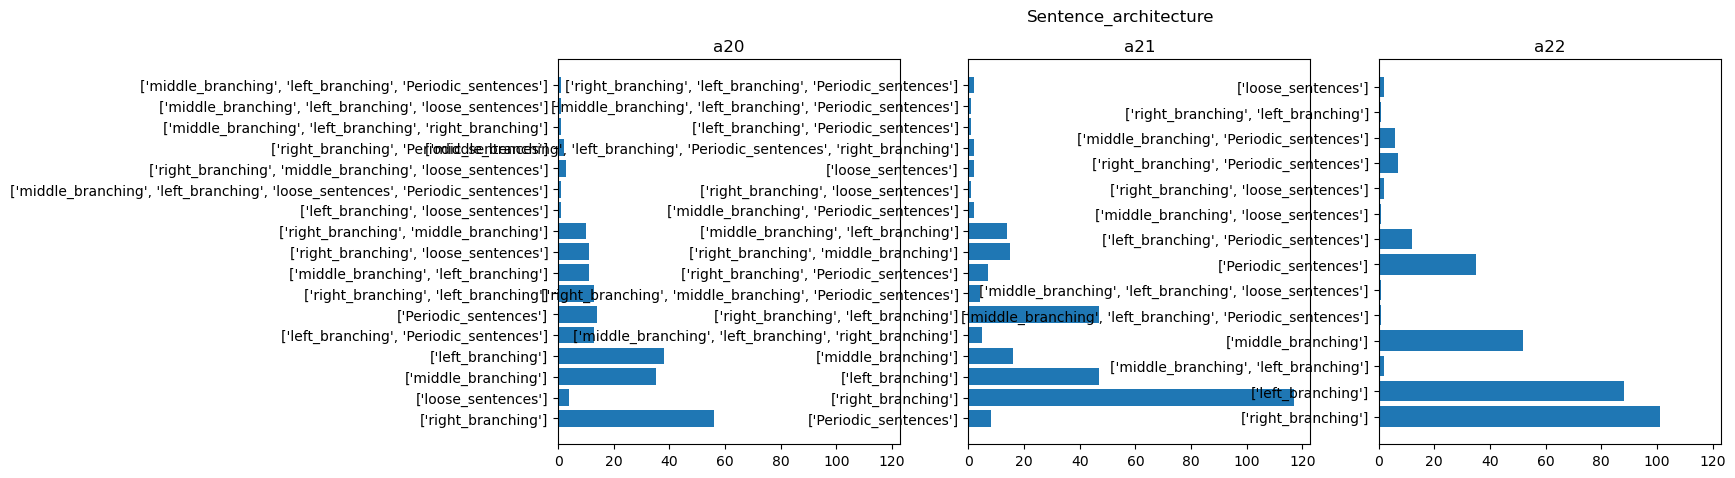

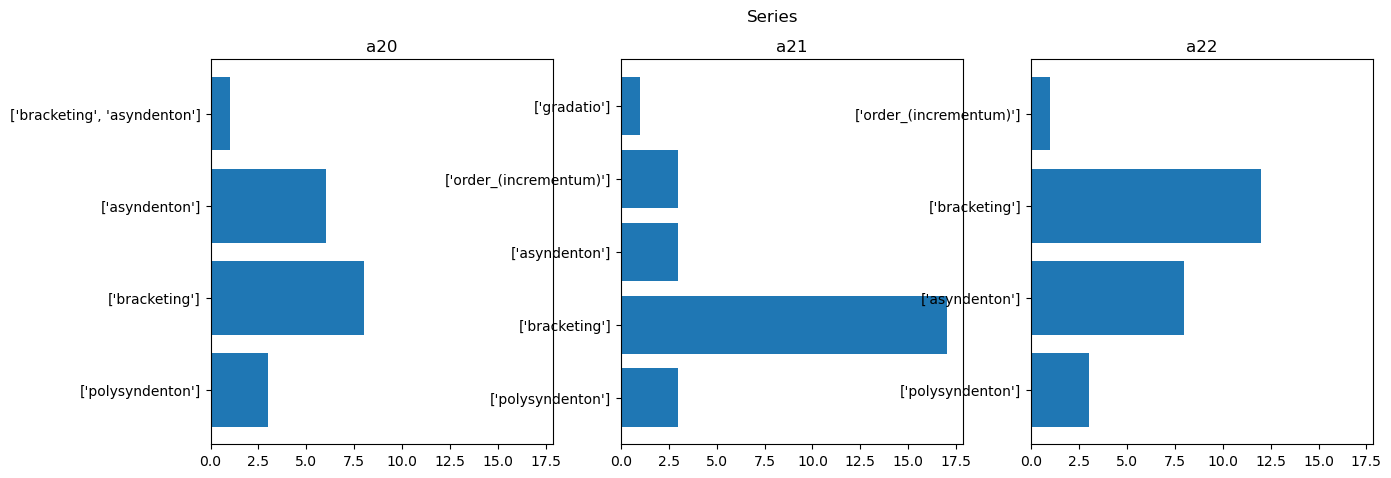

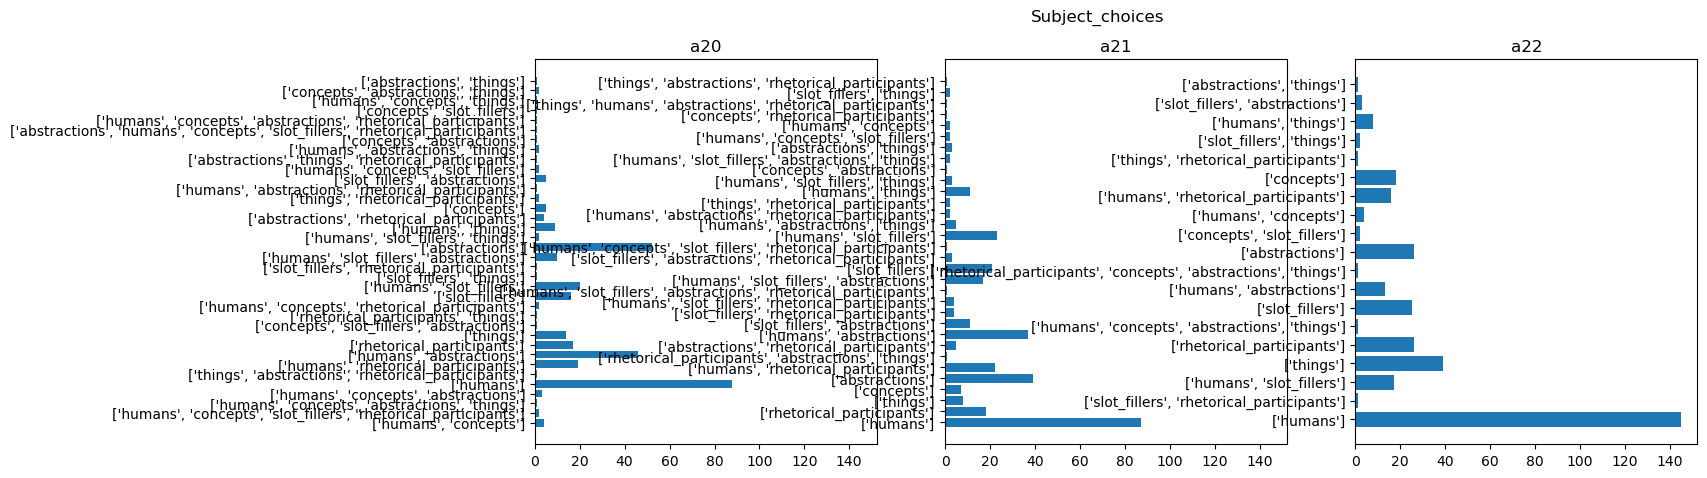

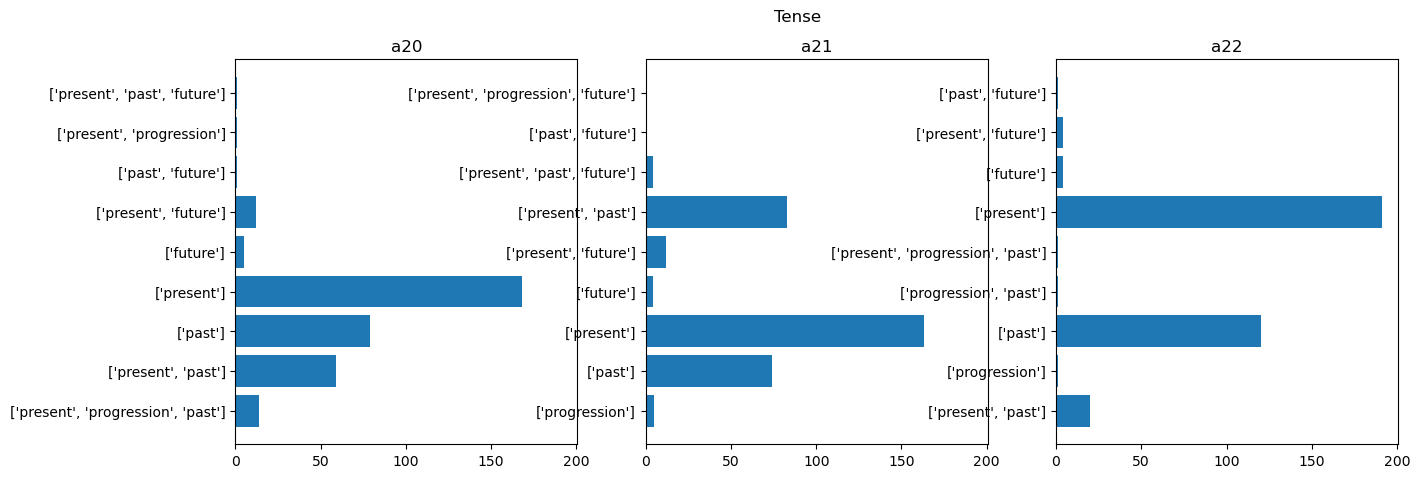

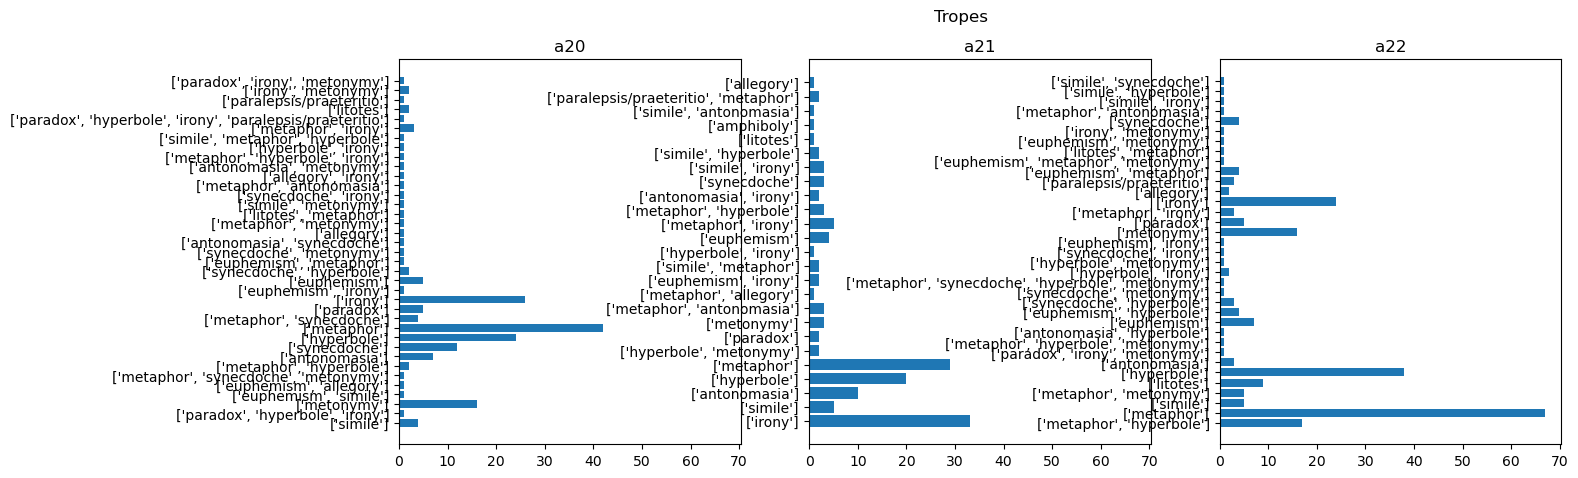

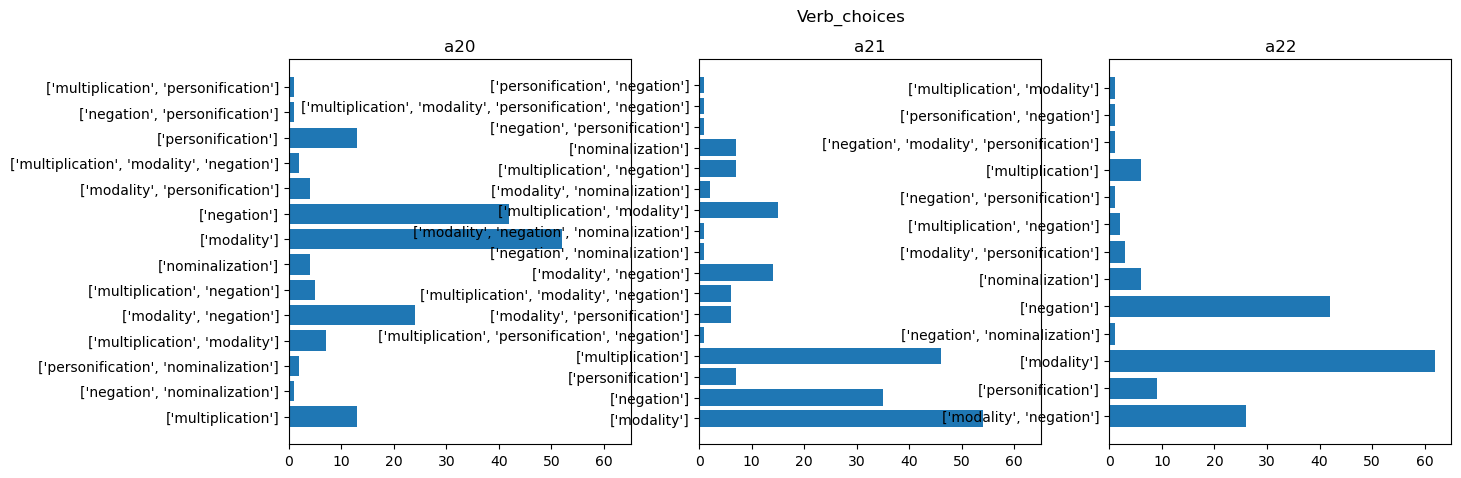

In [207]:
for feature in features:
    plotPropertyDistributions(feature,a_20,a_21,a_22)